In [2]:
import os
import sys
import torch
import math
import numpy as np
import botorch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns

cwd = os.getcwd()
src_dir = "/".join(cwd.split("/")[:-1])
sys.path.append(src_dir)

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll

torch.set_default_dtype(torch.float64)

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'h', 'H', 'X', 'D', 'd', '|', '_']
linestyles = ['-', '--', '-.', ':']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

FIG_DIR = './figs'

In [3]:
import os
# script_dir = os.path.dirname(__file__)
cwd = os.getcwd()
src_dir = "/".join(cwd.split("/")[:-1])
sys.path.append(src_dir)



/home/ccheng/dev/PSBAX/slide-scripts


In [3]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style('whitegrid',{'axes.grid': False})


d = 1
D0_size = 4
# def f(x):
#     return 5 * np.sin(7*x) ** 2 + 0.5 * x ** 3
means = torch.tensor([0.3, 0.7])  # Means of the Gaussians
stds = torch.tensor([0.1, 0.15]) # Standard deviations of the Gaussians
weights = torch.tensor([0.5, 0.5]) # Weights of the Gaussians, making the left mode higher
def f(x, means=means, stds=stds, weights=weights):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
    gaussians = [w * torch.exp(-0.5 * ((x - m) / s) ** 2) / (s * torch.sqrt(torch.tensor(2 * torch.pi))) for m, s, w in zip(means, stds, weights)]
    return torch.sum(torch.stack(gaussians), dim=0)

# plot the function
x_axis = torch.linspace(0, 1, 1000)
y_axis = f(x_axis)

noise_std = 0.1
D0_x = torch.tensor([
    [0.13],
    [0.2],
    [0.2857],
    [0.47],
    [0.5714],
    # [0.7143],
    # [0.9],
])
D0_y = f(D0_x) 
eps0 = torch.randn_like(D0_x) 
D0_y = D0_y + noise_std * eps0




In [4]:
def plot_f():
    ax.plot(x_axis, y_axis, label="$f$", color="C0")
# plot eps0 as a bar away from the true function
def plot_D_eps(Dx, Dy, label=None, color='C4'):
    n = Dx.shape[0]
    for i in range(n):
        ax.plot([Dx[i], Dx[i]], [Dy[i], f(Dx[i])], color=color, linestyle='-', alpha=0.5, zorder=0)
    if label is not None:
        ax.scatter(Dx, Dy, label=label, s=50, color='C4')
    else: 
        ax.scatter(Dx, Dy, s=50, color='C4')


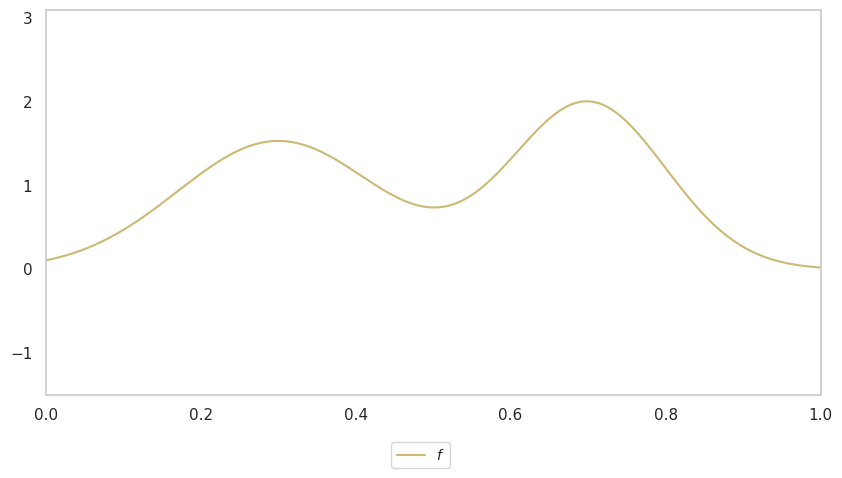

In [16]:
means2 = torch.tensor([0.3, 0.7])  # Means of the Gaussians
stds2 = torch.tensor([0.13, 0.1]) # Standard deviations of the Gaussians
weights2 = torch.tensor([0.5, 0.5]) # Weights of the Gaussians, making the left mode higher

def f2(x, means=means2, stds=stds2, weights=weights2):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
    gaussians = [w * torch.exp(-0.5 * ((x - m) / s) ** 2) / (s * torch.sqrt(torch.tensor(2 * torch.pi))) for m, s, w in zip(means, stds, weights)]
    return torch.sum(torch.stack(gaussians), dim=0)

# plot the function
y_axis2 = f2(x_axis)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x_axis, y_axis2, label="$f$", color="C8")

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
# plt.tight_layout()

plt.savefig(os.path.join(FIG_DIR, 'f2.svg'), bbox_inches='tight')

plt.show()


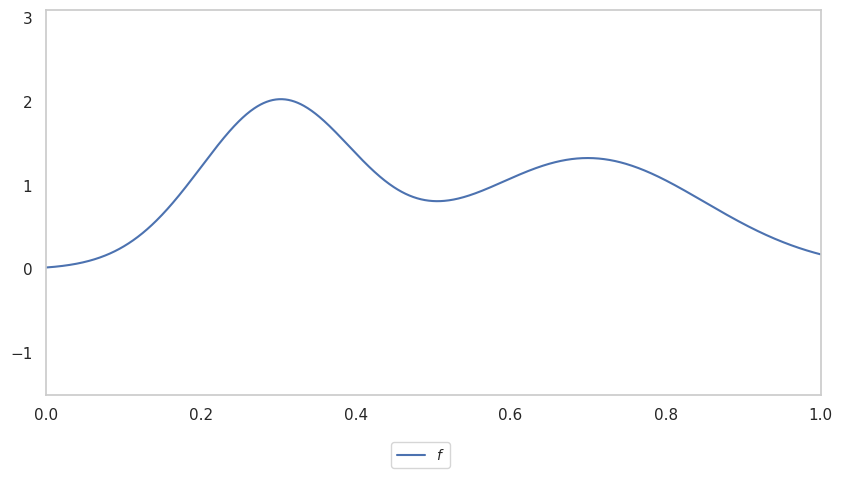

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
# plt.tight_layout()

plt.savefig(os.path.join(FIG_DIR, 'f.svg'), bbox_inches='tight')

plt.show()

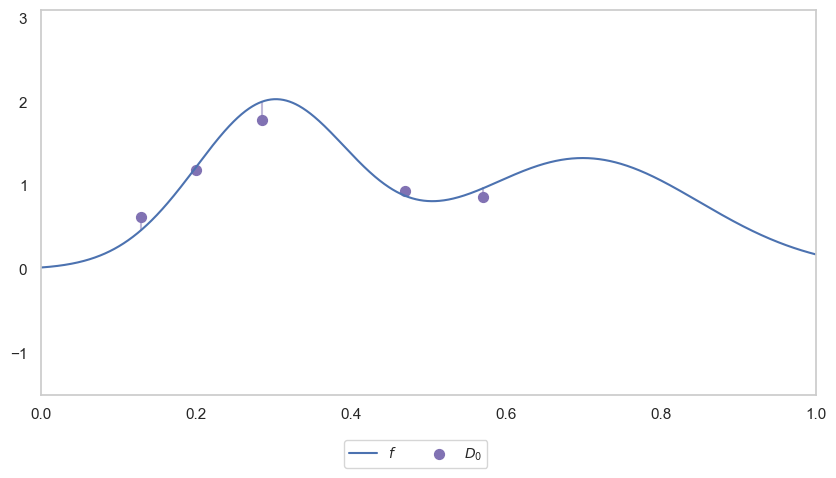

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()
# plot_D_eps(D0_x, D0_y, label="$D_0$")
# ax.plot([D0_x[0], D0_x[0]], [D0_y[0], f(D0_x[0])], color="C0", linestyle='--', alpha=0.5, zorder=0)
# ax.scatter(D0_x, D0_y, 
#            label="$D_0$", 
#            s=100, color='C4')

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
# plt.tight_layout()

plt.savefig(os.path.join(FIG_DIR, 'intro_data.svg'), bbox_inches='tight')

plt.show()

In [100]:
def fit_model(inputs, outputs):
    if len(outputs.shape) == 1:
        outputs = outputs.view(torch.Size([outputs.shape[0], 1]))
    model = SingleTaskGP(
        train_X=inputs,
        train_Y=outputs,
        covar_module=None,
        outcome_transform=Standardize(m=outputs.shape[-1]),
    )
    # register noise contraints to the model to be less than 1e-5
    model.likelihood.noise_covar.register_constraint(
        "raw_noise", Interval(1e-8, 1e-4)
    )
    model.covar_module.base_kernel.register_constraint(
        "raw_lengthscale", Interval(1.5e-1, 2e-1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    return model
# threshold = 1.1
kwargs = {}
model = fit_model(
    D0_x, D0_y
)
post = model.posterior(x_axis.reshape(-1, 1))
mu = post.mean.detach().numpy().flatten()
sigma = post.variance.sqrt().detach().numpy().flatten()

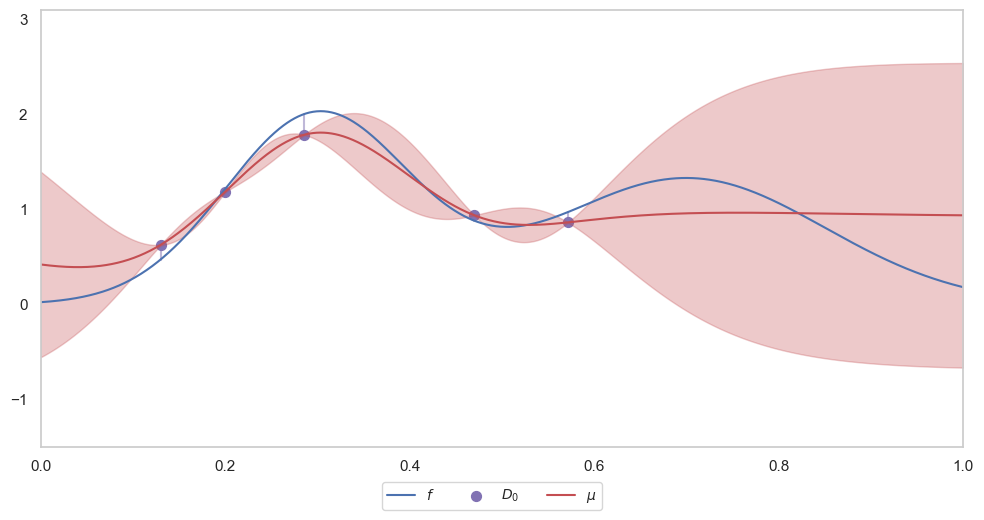

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()
plot_D_eps(D0_x, D0_y, label="$D_0$")
ax.plot(x_axis, mu, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu - 2 * sigma, mu + 2 * sigma, color='C3', alpha=0.3)
# ax.legend()

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_gp.svg'), bbox_inches='tight')
plt.show()

In [ ]:
# graph ucb acquisition function
def ucb(model, x, kappa=2):
    post = model.posterior(x)
    mu = post.mean
    sigma = post.variance.sqrt()
    return mu + kappa * sigma


kappa = 1


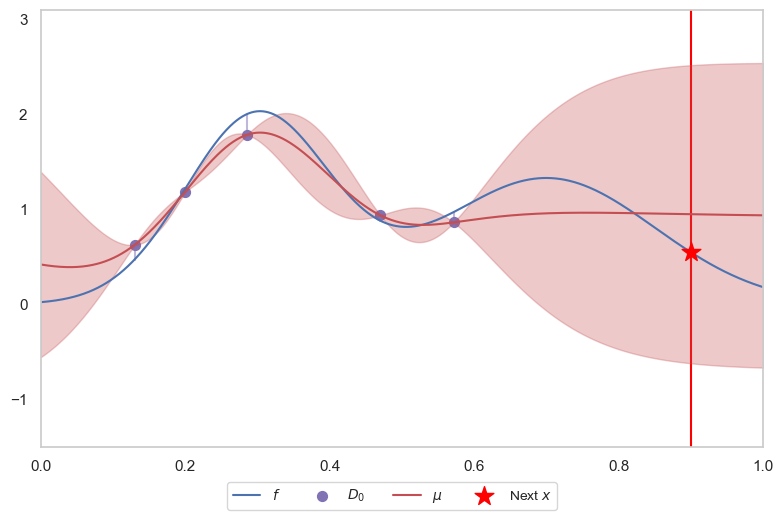

In [104]:
# exploration
x_explore = torch.tensor([[0.9]])
fx_explore = f(x_explore)
y_explore = fx_explore + noise_std * torch.randn_like(x_explore)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_f()
plot_D_eps(D0_x, D0_y, label="$D_0$")
ax.plot(x_axis, mu, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu - 2 * sigma, mu + 2 * sigma, color='C3', alpha=0.3)
# ax.legend()
ax.scatter(x_explore, fx_explore, marker="*", s=200, color='red', label="Next $x$", zorder=10)

# draw a vline
ax.vlines(x_explore, ymin=-1.5, ymax=3.1, color='red', zorder=0)

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_explore.svg'), bbox_inches='tight')
plt.show()

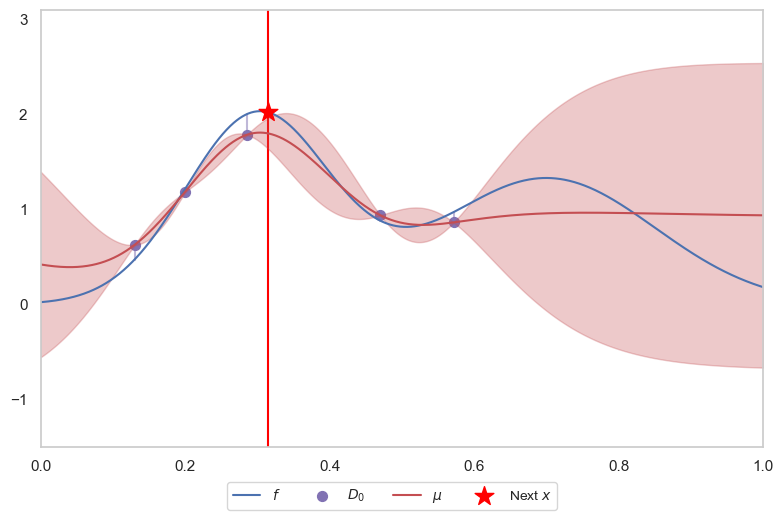

In [105]:
# exploitation

x_exploit = torch.tensor([[0.315]])
fx_exploit = f(x_exploit)
y_exploit = fx_exploit + noise_std * torch.randn_like(x_exploit)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_f()
plot_D_eps(D0_x, D0_y, label="$D_0$")
ax.plot(x_axis, mu, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu - 2 * sigma, mu + 2 * sigma, color='C3', alpha=0.3)
# ax.legend()
ax.scatter(x_exploit, fx_exploit, marker="*", s=200, color='red', label="Next $x$", zorder=10)

# draw a vline
ax.vlines(x_exploit, ymin=-1.5, ymax=3.1, color='red', zorder=0)

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_exploit.svg'), bbox_inches='tight')
plt.show()


In [ ]:
# models

model_explore = fit_model(
    torch.cat([D0_x, x_explore]),
    torch.cat([D0_y, y_explore])
)
post_explore = model_explore.posterior(x_axis.reshape(-1, 1))
mu_explore = post_explore.mean.detach().numpy().flatten()
sigma_explore = post_explore.variance.sqrt().detach().numpy().flatten()

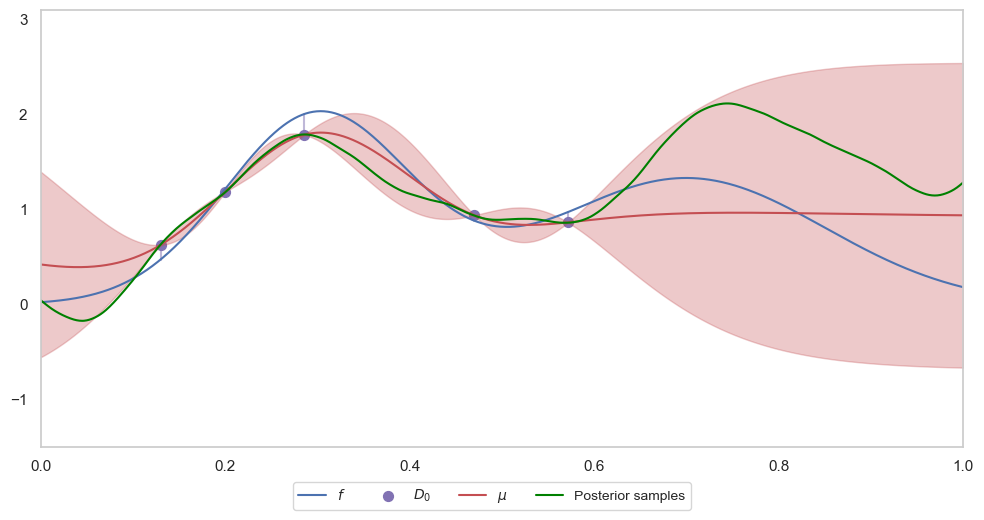

In [115]:
# Posterior sampling

samples = post.rsample().detach().squeeze()
argmax = torch.argmax(samples)
x_max = x_axis[argmax]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()
plot_D_eps(D0_x, D0_y, label="$D_0$")
ax.plot(x_axis, mu, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu - 2 * sigma, mu + 2 * sigma, color='C3', alpha=0.3)
ax.plot(x_axis, samples, label="Posterior samples", color='green')

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_PS1.svg'), bbox_inches='tight')
plt.show()

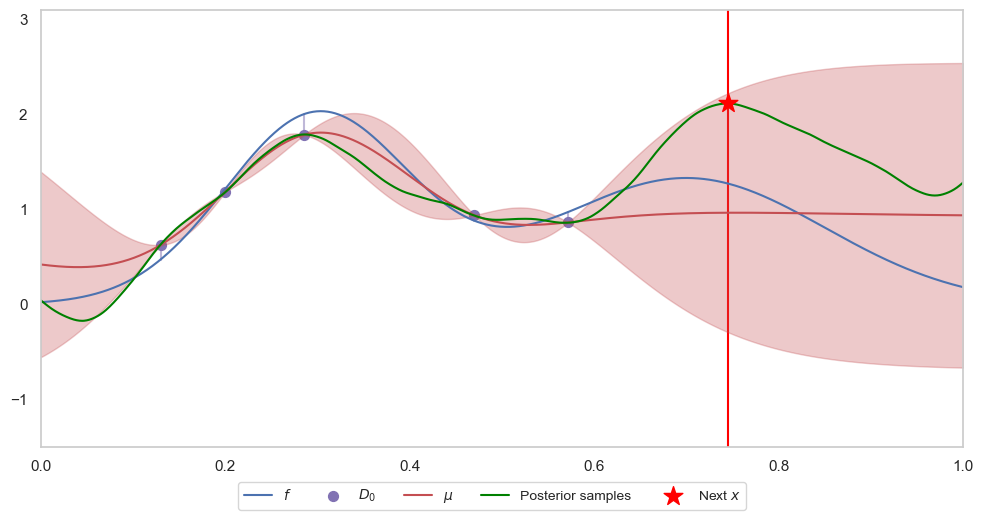

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()
plot_D_eps(D0_x, D0_y, label="$D_0$")
ax.plot(x_axis, mu, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu - 2 * sigma, mu + 2 * sigma, color='C3', alpha=0.3)
ax.plot(x_axis, samples, label="Posterior samples", color='green')
ax.scatter(x_max, samples[argmax], marker="*", s=200, color='red', label="Next $x$", zorder=10)
ax.vlines(x_max, ymin=-1.5, ymax=3.1, color='red', zorder=0)
ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_PS1_next.svg'), bbox_inches='tight')
plt.show()



In [119]:
x_max = x_max.view(-1, 1)
fx_max = f(x_max)   
y_max = fx_max + noise_std * torch.randn_like(x_max)
D1_x = torch.cat([D0_x, x_max])
D1_y = torch.cat([D0_y, y_max])


model2 = fit_model(
    D1_x, D1_y
)
post2 = model2.posterior(x_axis.reshape(-1, 1))
mu2 = post2.mean.detach().numpy().flatten()
sigma2 = post2.variance.sqrt().detach().numpy().flatten()

sample2 = post2.rsample().detach().squeeze()
argmax2 = torch.argmax(sample2)
x_max2 = x_axis[argmax2]



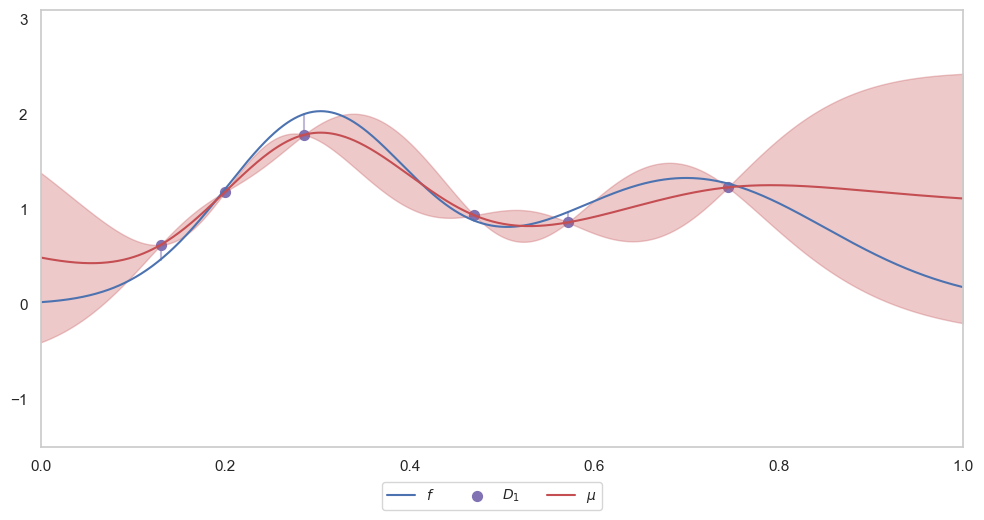

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()
plot_D_eps(D1_x, D1_y, label="$D_1$")
ax.plot(x_axis, mu2, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu2 - 2 * sigma2, mu2 + 2 * sigma2, color='C3', alpha=0.3)

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_PS2.svg'), bbox_inches='tight')
plt.show()

# ax.plot(x_axis, sample2, label="Posterior samples", color='green')



In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_f()
plot_D_eps(D1_x, D1_y, label="$D_1$")
ax.plot(x_axis, mu2, label="$\mu$", color='C3')
ax.fill_between(x_axis, mu2 - 2 * sigma2, mu2 + 2 * sigma2, color='C3', alpha=0.3)
ax.plot(x_axis, sample2, label="Posterior samples", color='green')

ax.set_xlim([0, 1])
ax.set_ylim([-1.5, 3.1])

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'intro_PS2.svg'), bbox_inches='tight')
plt.show()


